In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime
import re
from scipy import stats
import matplotlib.dates as mdates
# from pandas.plotting import register_matplotlib_converters

In [2]:
### output formats ###

OUTPUT_TEMPLATE = (
    'P-value of linear regression results (null hypothesis: slope of the regression line is 0)\n'
    '    p-value of style "American Adjunct Lager": {p_value1:.3g}\n'
    '    p-value of style "Belgian Strong Dark Ale": {p_value2:.3g}\n'
    '    p-value of style "American IPA": {p_value3:.3g}\n'
    '    p-value of style "American Pale Ale (APA)": {p_value4:.3g}\n'
    '    p-value of style "Belgian Tripel": {p_value5:.3g}\n'
)

In [3]:
### helper functions ###
datetime_pattern = re.compile(r'^(\S+) (\d+), (\d+)$')

def isdatetimeFormat(string): 
    # isdatetimeFormat(string) checks whether argument has good datetime format which can be converted into datetime object
    # by to_datetime(datelike_string) function. the format is "%b %d, %Y"
    match = datetime_pattern.match(string)
    if not match:
        return False
    month = match.group(1)
    date = int(match.group(2))
    year = int(match.group(3))
    if month not in ['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']:
        return False
    elif not( date >0 and date<32):
        return False
    elif year < 0:
        return False
    else: 
        return True

def to_datetime(datelike_string):
    ret = datelike_string[8:] #datelike_string[0:3] + datelike_string[8:]
    ret = datetime.datetime.strptime(ret, "%Y") #(ret, "%b%Y")
    return ret

def is_year_round(string):
    ret = (string == 'Year-round') #or (string=='Rotating')
    return ret

def to_timestamp(datetime_Object):
    return datetime.datetime.timestamp(datetime_Object)

def returnyear(dateObject):
    return dateObject.year

In [4]:
### ETL with canadian_data.csv ###
comment= pd.read_csv('data/canadian_data.csv')


/Users/richard/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3049: DtypeWarning: Columns (20) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [5]:
# read the csv file and only keep columns and rows required for analysis #
comment = comment[['ba_score','beer_number','style','availability','date']]
comment = comment[comment['style'].notnull()]
comment['is_year_round'] = comment['availability'].apply(is_year_round)
comment = comment[comment['is_year_round']== True]
del [comment['availability'],comment['is_year_round']]

# find top 5 beer sytles reviewed the most #
beer_kind = comment[['beer_number','style']].groupby('style').count()
beer_kind = beer_kind.sort_values(by='beer_number',ascending=False)
beer_kind = beer_kind.head(5)

# filter the top 5 beer styles from the data #
beer_kind = beer_kind.rename(columns={'beer_number':'indicator'})
comment = comment.join(beer_kind, on='style')
comment = comment[comment['indicator'].notnull()]
del comment['indicator']

# making sure 'date' column has string type and it is in good format for datetime conversion #
comment['isStr'] = comment['date'].apply(isinstance, args=(str,))
comment = comment[comment['isStr']==True]
comment['format'] = comment['date'].apply(isdatetimeFormat)
comment = comment[comment['format']==True]
comment['date'] = comment['date'].apply(to_datetime)
del [comment['isStr'], comment['format']]
# comment

# what are the number of review per year-month per style? #
counts = comment
counts = counts.rename(columns={'ba_score':'review counts'})
del counts['beer_number']
counts = counts.groupby(['style','date']).count()

# calculate mean 'ba_score' for each year-month for all beer styles #
means = comment
del means['beer_number']
means = means.groupby(['style','date']).mean()

# filter year-month with less then 3-0 reviews for all styles #
counts = counts.join(means, on=['style','date'])
del means
counts = counts.reset_index()
# print(counts.shape)
counts = counts[counts['review counts'] > 29]
# print(counts.shape)
# counts



In [6]:
### Statistical Testing ### 

# prepare for linear regression # 
counts = counts.groupby(['style','date']).mean()
counts = counts.unstack(level=0)
counts = counts.reset_index()
counts['timestamp'] = counts['date'].apply(to_timestamp)

# create mast to avoid Null values during regression #
mask1 = counts['ba_score']['American Adjunct Lager'].notnull()
mask2 = counts['ba_score']['Belgian Strong Dark Ale'].notnull()
mask3 = counts['ba_score']['American IPA'].notnull()
mask4 = counts['ba_score']['American Pale Ale (APA)'].notnull()
mask5 = counts['ba_score']['Belgian Tripel'].notnull()

# Execute linear regression for ba_scores #
lin1 = stats.linregress(counts['timestamp'][mask1], counts['ba_score']['American Adjunct Lager'][mask1])
lin2 = stats.linregress(counts['timestamp'][mask2], counts['ba_score']['Belgian Strong Dark Ale'][mask2])
lin3 = stats.linregress(counts['timestamp'][mask3], counts['ba_score']['American IPA'][mask3])
lin4 = stats.linregress(counts['timestamp'][mask4], counts['ba_score']['American Pale Ale (APA)'][mask4])
lin5 = stats.linregress(counts['timestamp'][mask5], counts['ba_score']['Belgian Tripel'][mask5])
prediction1 = lin1.slope * counts['timestamp'] + lin1.intercept
prediction2 = lin2.slope * counts['timestamp'] + lin2.intercept
prediction3 = lin3.slope * counts['timestamp'] + lin3.intercept
prediction4 = lin4.slope * counts['timestamp'] + lin4.intercept
prediction5 = lin5.slope * counts['timestamp'] + lin5.intercept

# create Hierarchical column 'Prediction' which contains prediction values of all styles #
predictions = {'American Adjunct Lager':prediction1, 'Belgian Strong Dark Ale':prediction2, 'American IPA':prediction3, 'American Pale Ale (APA)':prediction4, 'Belgian Tripel':prediction5}
predictions = pd.DataFrame(data=predictions)
predictions.columns = pd.MultiIndex.from_product([['Prediction'], ['American Adjunct Lager', 'Belgian Strong Dark Ale', 'American IPA', 'American Pale Ale (APA)', 'Belgian Tripel']]) 
counts = counts.join(predictions)
del predictions



P-value of linear regression results (null hypothesis: slope of the regression line is 0)
    p-value of style "American Adjunct Lager": 0.000108
    p-value of style "Belgian Strong Dark Ale": 0.668
    p-value of style "American IPA": 0.435
    p-value of style "American Pale Ale (APA)": 0.0265
    p-value of style "Belgian Tripel": 0.829



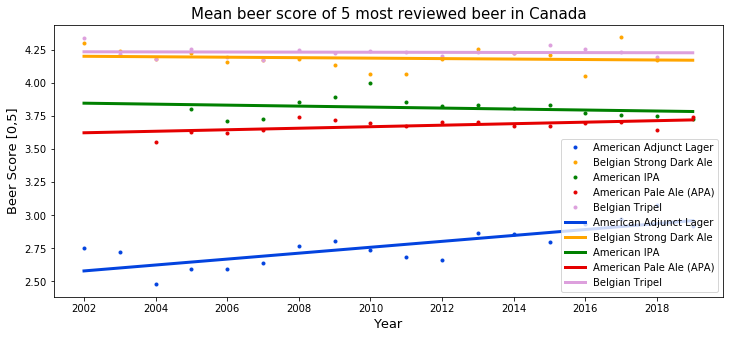

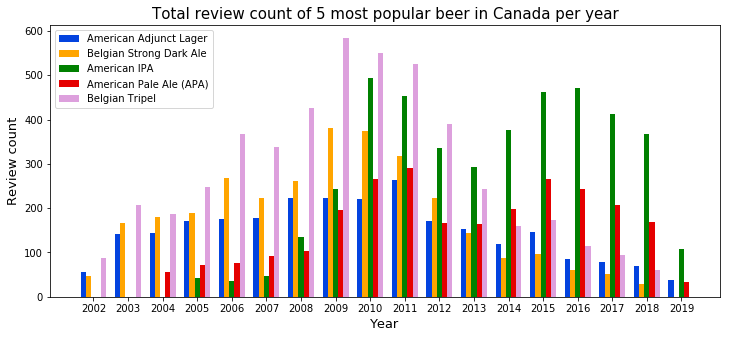

In [7]:
### Plot and print the results ###
pd.plotting.register_matplotlib_converters()
print(OUTPUT_TEMPLATE.format(
    p_value1=lin1.pvalue,
    p_value2=lin2.pvalue,
    p_value3=lin3.pvalue,
    p_value4=lin4.pvalue,
    p_value5=lin5.pvalue
))
plt.figure(figsize=(12,5))
plt.plot(counts['date'], counts['ba_score']['American Adjunct Lager'], color='xkcd:blue', marker='o', linestyle='', markersize=3)
plt.plot(counts['date'], counts['ba_score']['Belgian Strong Dark Ale'], color='orange', marker='o', linestyle='', markersize=3)
plt.plot(counts['date'], counts['ba_score']['American IPA'], color='green', marker='o',linestyle='', markersize=3)
plt.plot(counts['date'], counts['ba_score']['American Pale Ale (APA)'], color='xkcd:red', marker='o', linestyle='',markersize=3)
plt.plot(counts['date'], counts['ba_score']['Belgian Tripel'], color='plum',marker='o', linestyle='', markersize=3)
plt.plot(counts['date'], counts['Prediction']['American Adjunct Lager'], color='xkcd:blue', linewidth=3)
plt.plot(counts['date'], counts['Prediction']['Belgian Strong Dark Ale'], color='orange', linewidth=3)
plt.plot(counts['date'], counts['Prediction']['American IPA'], color='green', linewidth=3)
plt.plot(counts['date'], counts['Prediction']['American Pale Ale (APA)'], color='xkcd:red', linewidth=3)
plt.plot(counts['date'], counts['Prediction']['Belgian Tripel'], color='plum', linewidth=3)
plt.legend()
plt.title('Mean beer score of 5 most reviewed beer in Canada', fontsize=15)
plt.ylabel('Beer Score [0,5]', fontsize = 13)
plt.xlabel('Year', fontsize=13)
plt.savefig('canadian beer score.png')

plt.figure(figsize=(12,5))
X = counts['date'].apply(returnyear)
category = counts['ba_score'].columns.values
pos = np.arange(len(X))
bar_width = 0.15
plt.bar(pos, counts['review counts']['American Adjunct Lager'], bar_width, color="xkcd:blue")
plt.bar(pos+bar_width, counts['review counts']['Belgian Strong Dark Ale'], bar_width, color='orange')
plt.bar(pos+2*bar_width, counts['review counts']['American IPA'], bar_width, color='green')
plt.bar(pos+3*bar_width, counts['review counts']['American Pale Ale (APA)'], bar_width, color='xkcd:red')
plt.bar(pos+4*bar_width, counts['review counts']['Belgian Tripel'], bar_width, color='plum')
plt.legend(['American Adjunct Lager','Belgian Strong Dark Ale','American IPA','American Pale Ale (APA)','Belgian Tripel'], loc='upper left')
plt.xlabel('Year', fontsize=13)
plt.ylabel('Review count', fontsize=13)
plt.title('Total review count of 5 most popular beer in Canada per year', fontsize=15)
plt.xticks(pos+2*bar_width, X)
plt.savefig('canadian beer review counts.png')
plt.show()